# # Import libraries

In [34]:
import pymysql
pymysql.install_as_MySQLdb()
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Add project directory path, establish database connection, and load data

In [35]:
# Add project directory path
sys.path.append(os.path.abspath(".."))

# Establish database connection
from database.db_connection import DatabaseConnector

# Error handling for database connection
try:
    db_connector = DatabaseConnector()
    engine = db_connector.get_engine()
except Exception as e:
    print(f"Error connecting to the database: {e}")
    sys.exit(1)  # Exit program on connection error

# Load data
try:
    forecast_df = pd.read_sql("SELECT datetime, temperature_2m FROM historical_forecast;", engine)
    weather_df = pd.read_sql("SELECT datetime, temperature_2m FROM historical_weather;", engine)
except Exception as e:
    print(f"Error loading data: {e}")
    sys.exit(1)  # Exit program on error

# Convert datetime format
try:
    forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
except Exception as e:
    print(f"Error in datetime formatting: {e}")
    sys.exit(1)

# Ensure alignment of timestamps
forecast_df.set_index('datetime', inplace=True)
weather_df.set_index('datetime', inplace=True)

# Merge data to align timestamps for comparison
merged_df = pd.merge(forecast_df, weather_df, how='inner', left_index=True, right_index=True, suffixes=('_forecast', '_actual'))

# # 1. Histograms: Distribution of forecasted and actual temperatures

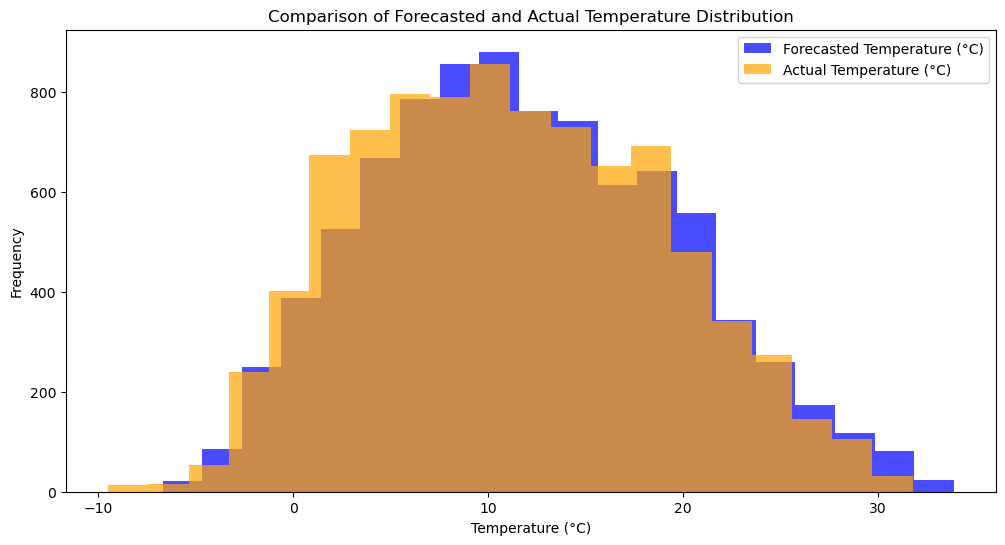

In [36]:
# Plot histogram for forecasted and actual temperatures
plt.figure(figsize=(12, 6))
plt.hist(merged_df['temperature_2m_forecast'], bins=20, alpha=0.7, label='Forecasted Temperature (°C)', color='blue')
plt.hist(merged_df['temperature_2m_actual'], bins=20, alpha=0.7, label='Actual Temperature (°C)', color='orange')
plt.title("Comparison of Forecasted and Actual Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Interpretation

The histogram compares the distribution of forecasted temperatures (blue) and actual temperatures (orange). There is significant overlap between the two, indicating that the forecasts generally align well with the observed temperatures. However, slight discrepancies in specific temperature ranges, such as at the extremes, suggest areas for potential improvement in the forecasting model.

# 2. Boxplot: Comparison of forecasted and actual temperatures by month

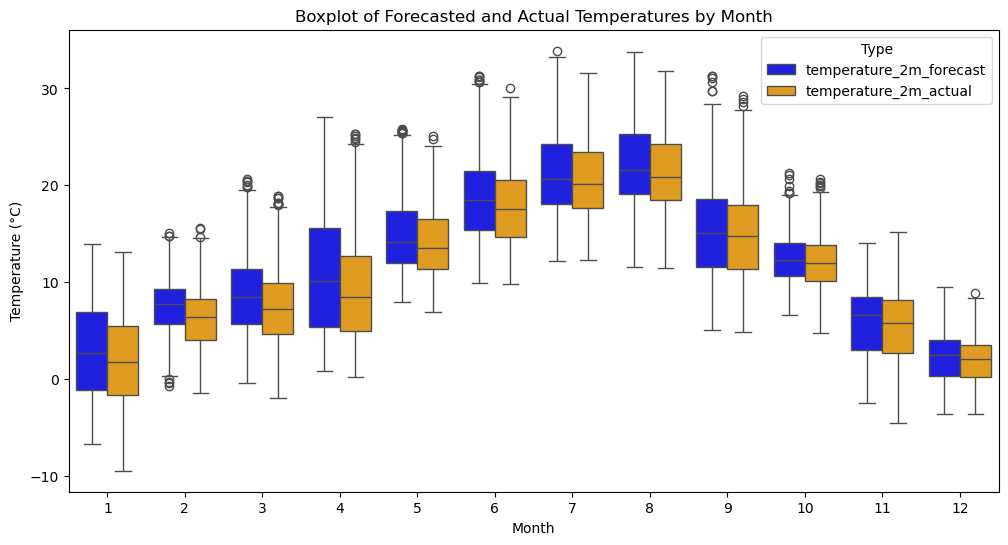

In [37]:
merged_df['month'] = merged_df.index.month
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df.melt(id_vars='month', value_vars=['temperature_2m_forecast', 'temperature_2m_actual'], 
                                var_name='Type', value_name='Temperature'), x='month', y='Temperature', hue='Type', palette={'temperature_2m_forecast':'blue', 'temperature_2m_actual':'orange'})
plt.title("Boxplot of Forecasted and Actual Temperatures by Month")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.legend(title='Type')
plt.show()

## Interpretation

The boxplot illustrates seasonal trends. Warmer months (e.g., June to August) show higher median temperatures, while colder months (e.g., December to February) have lower medians.

Outliers in the colder months might indicate unusual weather events or data irregularities.


# 3. Scatterplot: Forecasted vs Actual Temperatures

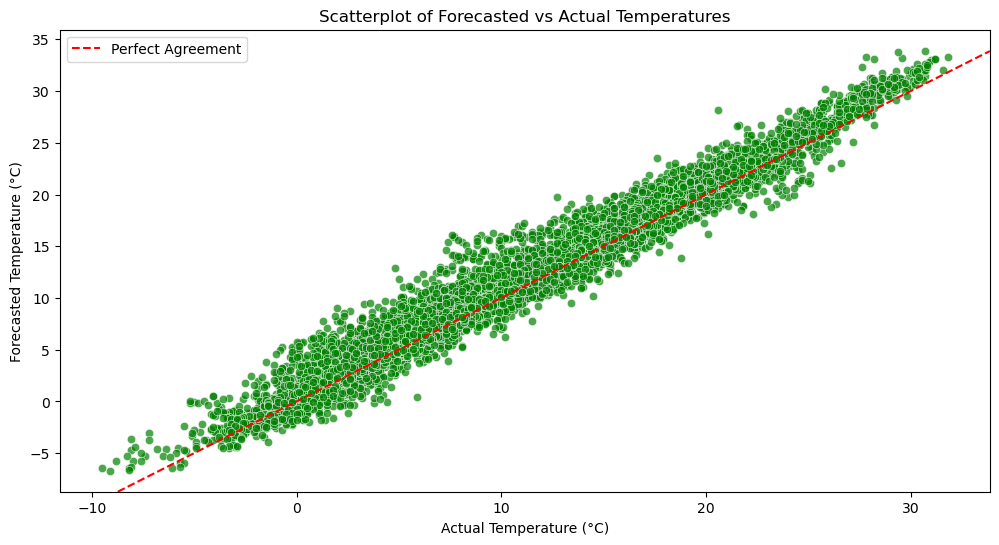

In [38]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='temperature_2m_actual', y='temperature_2m_forecast', alpha=0.7, color='green')
plt.title("Scatterplot of Forecasted vs Actual Temperatures")
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Forecasted Temperature (°C)")
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Perfect Agreement')
plt.legend()
plt.show()

## Interpretation


This scatterplot compares actual temperatures (x-axis) to forecasted temperatures (y-axis). The red dashed line represents perfect agreement, where forecasted and actual values would be equal. The points closely clustering around the line indicate that the forecasts align well with the actual data, with slight deviations in some areas. This demonstrates the reliability of the forecast, with room for improvement in specific temperature ranges.


# 4. Time series analysis: Forecasted vs Actual Temperatures Over Time

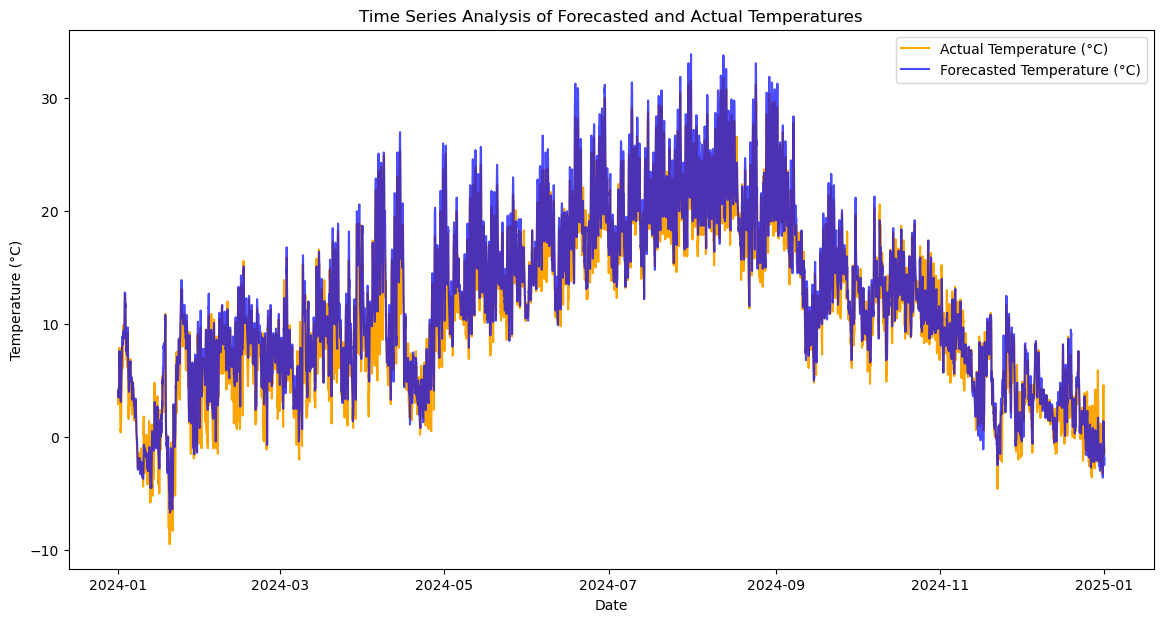

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(merged_df.index, merged_df['temperature_2m_actual'], label='Actual Temperature (°C)', color='orange')
plt.plot(merged_df.index, merged_df['temperature_2m_forecast'], label='Forecasted Temperature (°C)', color='blue', alpha=0.7)
plt.title("Time Series Analysis of Forecasted and Actual Temperatures")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

## Interpretation

This time series plot compares forecasted temperatures (blue) with actual temperatures (orange) over time. The two lines closely follow each other, demonstrating that the forecasts capture seasonal trends and daily fluctuations in temperature reasonably well. However, occasional divergences suggest areas where the forecast deviates from the actual observations, which could be explored further for specific patterns or outliers.

## 5. Correlation Heatmap


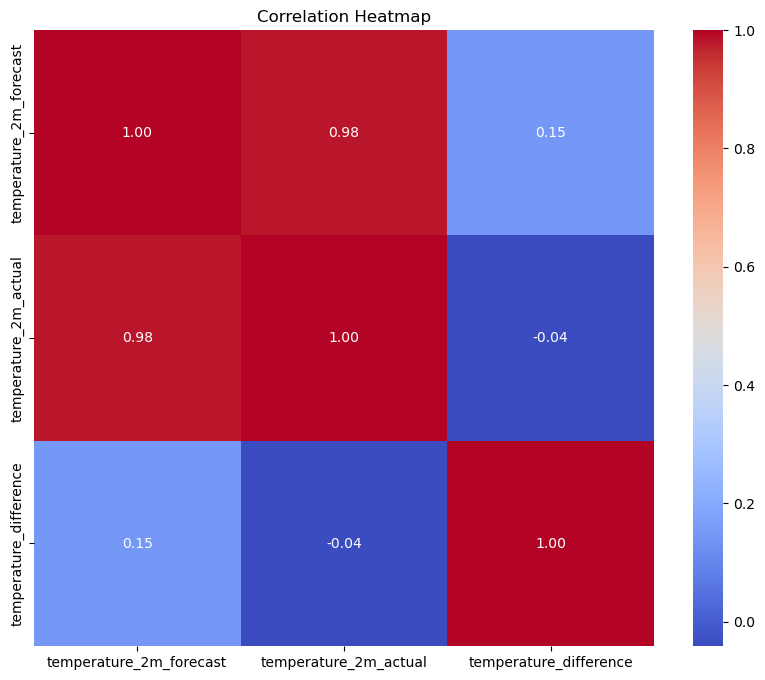

In [40]:
# Calculate temperature difference
merged_df['temperature_difference'] = merged_df['temperature_2m_forecast'] - merged_df['temperature_2m_actual']

plt.figure(figsize=(10, 8))
correlation_matrix = merged_df[['temperature_2m_forecast', 'temperature_2m_actual', 'temperature_difference']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

## Interpretation

This correlation heatmap visualizes the relationships between forecasted temperatures, actual temperatures, and their differences. Key observations:

Forecasted vs. Actual Temperatures (0.98): A very strong positive correlation indicates that the forecasts align closely with the actual values.
Forecasted Temperatures vs. Differences (0.15): A weak positive correlation suggests that higher forecasted temperatures are slightly associated with larger differences.
Actual Temperatures vs. Differences (-0.04): A near-zero or weak negative correlation implies no significant relationship between actual temperatures and the magnitude of forecast errors.
This heatmap confirms the strong predictive quality of the forecast while highlighting minimal systemic bias in error distribution.